# I. Entendimento do negócio

## 1. Dicionários de dados

FEATURE	| DESCRIPTION
-- | --
Date | Data das informações
Presença de Criadouros | Porcentagem da área com presença de mosquitos
Falta de Coleta de Lixo | Taxa de coleta de lixo realizada
Água Parada em Terrenos Baldios | Porcentagem da área com presença de água parada
Presença de Piscinas sem Manutenção | Número de piscinas sem manutenção observadas
Área com Acúmulo de Entulho | Porcentagem da área com entulho
Conscientização da População | Nível de conscientização sobre a dengue
Condições de Moradia Precárias | Taxa de moradias precárias na área observada
Falta de Acesso a Serviços de Saúde | Taxa de moradores sem acesso a serviços de saúde
Migração de Pessoas de Áreas Endêmicas | Taxa de migração entre áreas
Transporte de Mercadorias em Áreas Urbanas | Porcentagem de veículos de transporte de cargas
Falta de Controle de Pragas | Porcentagem da área observada sem controle de pragas
Presença de Recipientes sem Tampas | Número de recipientes observados no dia
Precipitação | Água proveniente do vapor de água atmosférica depositada na superfície
Taxa de Tratamento de Esgoto | Porcentagem de esgoto não tratado na área observada
Umidade | Relação entre a pressão parcial da água contida no ar e a pressão de vapor da água à temperatura do ar
Temperatura | Calor da atmosfera, medido em graus Celsius (ºC)
Presença de mosquito | Quantidade de mosquitos observada
Casos de dengue | Total de número de casos observados no dia

# II. Entendimento dos dados

## 0. IMPORTS

### 0.1. Importing libraries

In [96]:
# Data wrangling
import pandas as pd
import numpy as np
from unidecode import unidecode
import inflection
import math
import datetime

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Model Selection and Validation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Preprocessing for Pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder

# Models
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor # Baseline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Model Deployment
import pickle

# Configure sklearn to output DataFrames: Manter saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output='pandas')

### 0.2. Helper functions

In [293]:
# DATA DESCRIPTION ---------------------------------------------------------------------------------------------------------------

def data_description(data):

    # 1. Data Dimensions
    print('*' * 20 + ' DATA DIMENSIONS ' + '*' * 20)
    print('Quantidade de linhas: {:,}'.format(data.shape[0]))
    print('Quantidade de colunas: {:,}'.format(data.shape[1]))
    print()

    # 2. Data Types
    print('*' * 20 + ' DATA TYPES ' + '*' * 25)
    print(data.dtypes)
    print()

    # 3. Check NA's
    print('*' * 20 + ' CHECK NAs ' + '*' * 26)
    print(data.isna().sum())
    print()

    # 4. Check duplicated
    print('*' * 20 + ' CHECK DUPLICATED ' + '*' * 19)
    print('Quantidade de registros duplicados: {:,}'.format(data.duplicated().sum()))

# DATA WRANGLING -----------------------------------------------------------------------------------------------

def rename_columns(cols):
    cols = list(map(lambda x: inflection.titleize(x), cols))
    cols = list(map(lambda x: x.replace(' ', ''), cols))
    cols = list(map(lambda x: unidecode(x), cols))
    cols = list(map(lambda x: inflection.underscore(x), cols))
    return cols

# Classifica por nível de proliferação
def definir_proliferacao(semana):
    if 23 <= semana <= 38: return 'baixa'
    elif semana < 14 or semana > 48: return 'alta'
    else: return 'media'
    
# Calcula a média por período (semana)
def preencher_media_semana(data, col):
    for semana in data['semana_do_ano'].unique():
        mediana_da_semana = data.loc[data['semana_do_ano'] == semana, col].median()
        faltantes = data.loc[data[col].isna(), :].index
        data[col] = data[col].apply(lambda x: mediana_da_semana if math.isnan(x) else x)

# Identifica outliers em todas as colunas
def identificar_outliers(data_raw, colunas):
    data = data_raw.copy()
    outliers = {}
    data['outlier'] = 'Não'

    for col in colunas:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identificar outliers
        outliers_mask = (data[col] < lower_bound) | (data[col] > upper_bound)
        data.loc[outliers_mask, 'outlier'] = 'Sim'
        outliers[col] = data[outliers_mask].shape[0]
    
    return data, outliers

# DATA CLEANING ---------------------------------------------------------------------------------------------------------------

def data_cleaning(data_raw, colunas_float, colunas_int):

    # Faz uma cópia do dataframe
    data = data_raw.copy()

    # 1. Renomear colunas
    data.columns = rename_columns(data.columns)

    # 2. Remover duplicatas
    data = data.drop_duplicates().reset_index(drop=True)

    # 3. Transformar 'indisponivel' em NA
    for col in colunas_float:
        if 'indisponivel' in data[col].values:
            data[col] = data[col].replace('indisponivel', np.nan)
    
    # 4. Substituir ',' por '.' e Converter colunas_float de object para float
    for col in colunas_float:
        if data[col].astype(str).str.contains(',').any():
            data[col] = data[col].str.replace(',', '.', regex=False).astype(float)
   
    # 5. Converter date para o tipo datetime
    data['date'] = pd.to_datetime(data['date'])

    # 6. Converter colunas_int de object para numerico
    for col in colunas_int:
        data[col] = pd.to_numeric(data[col], errors='coerce')  # coerce errors to NaN

    # 7. Incluir novas features
    data = feature_engineering(data)

    # 8. Preencher NA's colunas_int
    for col in colunas_int:
        mediana = data[col].median()
        data[col] = data[col].fillna(mediana)

    # 9. Preencher NA's colunas_float com a média por semana do ano
    #for col in colunas_float:
    #    preencher_media_semana(data, col)

    # 9. Preencher os demais NA's
    #data.fillna(0, inplace=True)

    # 10. Converter colunas_int de object para int
    for col in colunas_int:
        data[col] = data[col].astype(int)    

    return data

# FEATURE ENGINEERING ---------------------------------------------------------------------------------------------------------------

def feature_engineering(data_raw):
    # Faz uma cópia do dataframe
    data = data_raw.copy()

    # 1. Separar data
    data['mes'] = data['date'].dt.month
    data['semana_do_ano'] = data['date'].dt.isocalendar().week

    # 2. Classifica por nível de proliferação
    data['proliferacao'] = data['semana_do_ano'].apply(lambda x: definir_proliferacao(x))

    # 3. Incluir coluna que identifica outliers
    colunas_numericas = colunas_float + colunas_int
    data, _ = identificar_outliers(data, colunas_numericas)

    return data

# DATA PREPARATION -------------------------------------------------------------------------------------------

# Cyclical encoding with sine/cosine transformation
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# MODEL VALIDATION --------------------------------------------------------------------------------------------------------------------

# Medir a performance do modelo
def get_metrics(y_true, y_pred):
    dict_metrics  = {
        'R2': float(metrics.r2_score(y_true, y_pred)),
        'MAE': float(metrics.mean_absolute_error(y_true, y_pred)),
        'MAPE': float(metrics.mean_absolute_percentage_error(y_true, y_pred)),
        'RMSE': float(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    }
    return dict_metrics

### 0.3. Loading data

In [254]:
path = '../data/'

tb_fato                 = pd.read_csv(path + 'tb_fato.csv', low_memory=False, decimal='.')
tb_casos_dengue         = pd.read_csv(path + 'tb_casos_dengue.csv', low_memory=False, decimal='.')
tb_agua_parada          = pd.read_csv(path + 'tb_agua_parada.csv', low_memory=False, decimal='.')
tb_condicoes_climaticas = pd.read_csv(path + 'tb_condicoes_climaticas.csv', low_memory=False, decimal='.')
tb_falta_higiene        = pd.read_csv(path + 'tb_falta_higiene.csv', low_memory=False, decimal='.')
tb_conscientizacao      = pd.read_csv(path + 'tb_conscientizacao.csv', low_memory=False, decimal='.')

#### 0.3.1 Unir tabelas

In [255]:
# Unir tabelas
df_raw = pd.merge(tb_fato, tb_casos_dengue, how='left', on='Date', suffixes=('_fato', '_casos'))
df_raw = df_raw.merge(tb_agua_parada, how='left', on='Date', suffixes=('', '_agua'))
df_raw = df_raw.merge(tb_condicoes_climaticas, how='left', on='Date', suffixes=('', '_cli'))
df_raw = df_raw.merge(tb_falta_higiene, how='left', on='Date', suffixes=('', '_hig'))
df_raw = df_raw.merge(tb_conscientizacao, how='left', left_on='conscientização da população', right_on='id', suffixes=('', '_consc'))

#### 0.3.2. Separar o arquivo de teste

In [256]:
# Separar o arquivo de teste (os últimos 1500 dias, onde os casos de dengue estão faltando)
df_teste_raw = df_raw.loc[df_raw['Casos de dengue'].isna(), :].reset_index(drop=True)

# Remover os dados da amostra
casos_faltantes = df_raw.loc[df_raw['Casos de dengue'].isna(), :].index
df_raw = df_raw.drop(casos_faltantes, axis=0).reset_index(drop=True)

## 1. DATA DESCRIPTION

Impressão da descrição dos dados antes da limpeza (Data Cleaning)

In [276]:
# Descrição dos dados sem modificação
print('*' *9 + ' Descrição dos dados de treino | Antes ' + '*' *9)
data_description(df_raw)

********* Descrição dos dados de treino | Antes *********
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 24,028
Quantidade de colunas: 22

******************** DATA TYPES *************************
Date                                           object
conscientização da população                    int64
condições de moradia precárias                 object
falta de acesso a serviços de saúde            object
migração de pessoas de áreas endêmicas         object
transporte de mercadorias em áreas urbanas     object
outros                                         object
presença do mosquito                           object
Casos de dengue                               float64
Presença de Criadouros                         object
Água Parada em Terrenos Baldios                object
Presença de Piscinas sem Manutenção            object
Presença de Recipientes sem Tampas             object
Precipitação                                   object
Umidade       

In [277]:
# Descrição dos dados de teste sem modificação
print('*' *10 + ' Descrição dos dados de teste | Antes ' + '*' *9)
data_description(df_teste_raw)

********** Descrição dos dados de teste | Antes *********
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 3,000
Quantidade de colunas: 22

******************** DATA TYPES *************************
Date                                           object
conscientização da população                    int64
condições de moradia precárias                 object
falta de acesso a serviços de saúde            object
migração de pessoas de áreas endêmicas         object
transporte de mercadorias em áreas urbanas     object
outros                                         object
presença do mosquito                           object
Casos de dengue                               float64
Presença de Criadouros                         object
Água Parada em Terrenos Baldios                object
Presença de Piscinas sem Manutenção            object
Presença de Recipientes sem Tampas             object
Precipitação                                   object
Umidade        

## 3. FEATURE ENGINEERING

{'precipitacao': 1110,
 'umidade': 146,
 'temperatura': 145,
 'casos_de_dengue': 2358,
 'presenca_do_mosquito': 0}

 Tô pensando em deletar todos os casos de dengue que são outliers

In [295]:
df = feature_engineering(df)
df.head()

,casos_de_dengue,presenca_do_mosquito,precipitacao,umidade,temperatura,date,mes,semana_do_ano,proliferacao,outlier
0,270499,874324,168.814638,88.117339,37.113825,1987-01-01,1,1,alta,Sim
1,279224,869290,148.661492,61.232582,29.596003,1987-01-02,1,1,alta,Sim
2,221681,880145,267.744475,NaN,26.844099,1987-01-03,1,1,alta,Sim
3,76197,295600,162.011169,NaN,29.870342,1987-01-04,1,1,alta,Não
4,94530,681702,278.151803,77.434816,29.418697,1987-01-05,1,2,alta,Sim


In [296]:
df_outliers, _ = identificar_outliers(df, colunas_numericas)
df_outliers[df_outliers['outlier'] == 'Sim']

,casos_de_dengue,presenca_do_mosquito,precipitacao,umidade,temperatura,date,mes,semana_do_ano,proliferacao,outlier
0,270499,874324,168.814638,88.117339,37.113825,1987-01-01,1,1,alta,Sim
1,279224,869290,148.661492,61.232582,29.596003,1987-01-02,1,1,alta,Sim
2,221681,880145,267.744475,NaN,26.844099,1987-01-03,1,1,alta,Sim
4,94530,681702,278.151803,77.434816,29.418697,1987-01-05,1,2,alta,Sim
6,177773,363188,179.537352,60.299537,30.398520,1987-01-07,1,2,alta,Sim
...,...,...,...,...,...,...,...,...,...,...
11770,163391,829146,242.132957,82.744054,22.099821,2019-03-24,3,12,alta,Sim
11773,238518,769116,124.496062,75.401390,28.619326,2019-03-27,3,13,alta,Sim
11774,198047,562019,209.516534,94.582152,25.523840,2019-03-28,3,13,alta,Sim
11775,133892,713737,151.852995,68.589263,28.964314,2019-03-29,3,13,alta,Sim


In [297]:
_, num_outliers = identificar_outliers(df, colunas_numericas)
num_outliers

{'precipitacao': 1134,
 'umidade': 0,
 'temperatura': 0,
 'casos_de_dengue': 1807,
 'presenca_do_mosquito': 0}

In [298]:
df[df['outlier'] == 'Sim']

,casos_de_dengue,presenca_do_mosquito,precipitacao,umidade,temperatura,date,mes,semana_do_ano,proliferacao,outlier
0,270499,874324,168.814638,88.117339,37.113825,1987-01-01,1,1,alta,Sim
1,279224,869290,148.661492,61.232582,29.596003,1987-01-02,1,1,alta,Sim
2,221681,880145,267.744475,NaN,26.844099,1987-01-03,1,1,alta,Sim
4,94530,681702,278.151803,77.434816,29.418697,1987-01-05,1,2,alta,Sim
6,177773,363188,179.537352,60.299537,30.398520,1987-01-07,1,2,alta,Sim
...,...,...,...,...,...,...,...,...,...,...
11770,163391,829146,242.132957,82.744054,22.099821,2019-03-24,3,12,alta,Sim
11773,238518,769116,124.496062,75.401390,28.619326,2019-03-27,3,13,alta,Sim
11774,198047,562019,209.516534,94.582152,25.523840,2019-03-28,3,13,alta,Sim
11775,133892,713737,151.852995,68.589263,28.964314,2019-03-29,3,13,alta,Sim


## 2. DATA CLEANING

In [294]:
# Colunas selecionadas para análise = 'date', 'status', 'precipitacao', 'umidade', 'temperatura', 'presenca_do_mosquito', 'casos_de_dengue'
# Numéricas: 'casos_de_dengue', 'presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura' 
# Categóricas: 'status' 
# Data: 'date'

colunas_float = ['precipitacao',
                 'umidade',
                 'temperatura']

colunas_int = ['casos_de_dengue',
               'presenca_do_mosquito']

df_cleaned = data_cleaning(df_raw, colunas_float, colunas_int)
selected_rows = colunas_int + colunas_float + ['date']

# Imprimir descrição dos dados depois da limpeza
print('*' *9 + ' Descrição dos dados de treino | DEPOIS ' + '*' *8)
data_description(df_cleaned[selected_rows])

df = df_cleaned[selected_rows].copy()


********* Descrição dos dados de treino | DEPOIS ********
******************** DATA DIMENSIONS ********************
Quantidade de linhas: 12,014
Quantidade de colunas: 6

******************** DATA TYPES *************************
casos_de_dengue                  int64
presenca_do_mosquito             int64
precipitacao                   float64
umidade                        float64
temperatura                    float64
date                    datetime64[ns]
dtype: object

******************** CHECK NAs **************************
casos_de_dengue           0
presenca_do_mosquito      0
precipitacao            122
umidade                 131
temperatura             127
date                      0
dtype: int64

******************** CHECK DUPLICATED *******************
Quantidade de registros duplicados: 0


In [265]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
casos_de_dengue,12014.0,43333.574496,0.0,801.75,10595.0,41289.25,756493.0,77404.369451
presenca_do_mosquito,12014.0,283663.928417,1023.0,64312.75,197310.0,438702.5,999530.0,266310.255766
precipitacao,11892.0,84.726599,0.009322,27.677821,54.048331,108.069367,299.966579,78.79728
umidade,11883.0,65.978617,40.005175,56.542314,65.346156,74.680604,94.995987,12.933879
temperatura,11887.0,25.228833,14.003989,21.561651,24.92955,28.579829,37.991244,5.316454
date,12014,2003-06-12 12:00:00,1987-01-01 00:00:00,1995-03-23 06:00:00,2003-06-12 12:00:00,2011-09-01 18:00:00,2019-11-22 00:00:00,NaN


## 4. EXPLORATORY DATA ANALYSIS (EDA)

### 4.1.  Análise Multivariada

<Axes: >

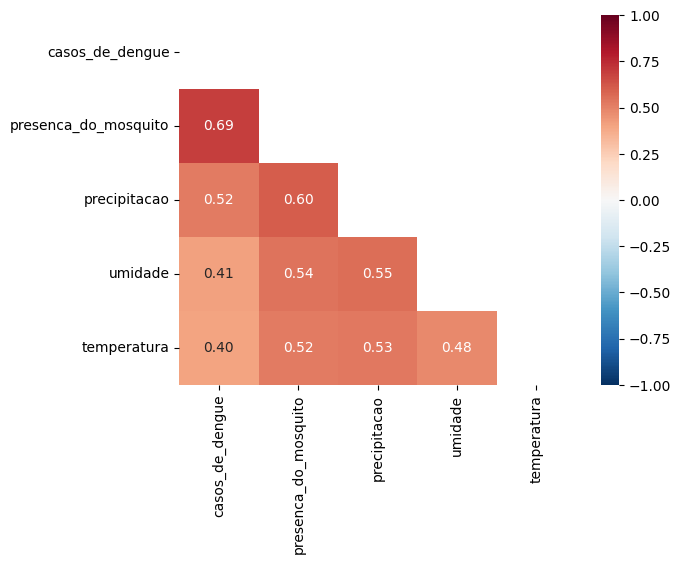

In [103]:
dfc = df[['casos_de_dengue', 'presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura']].corr()
mask  = np.zeros(dfc.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(dfc, annot=True, fmt='.2f', center=0, vmax=1, vmin=-1, cmap='RdBu_r', mask=mask)

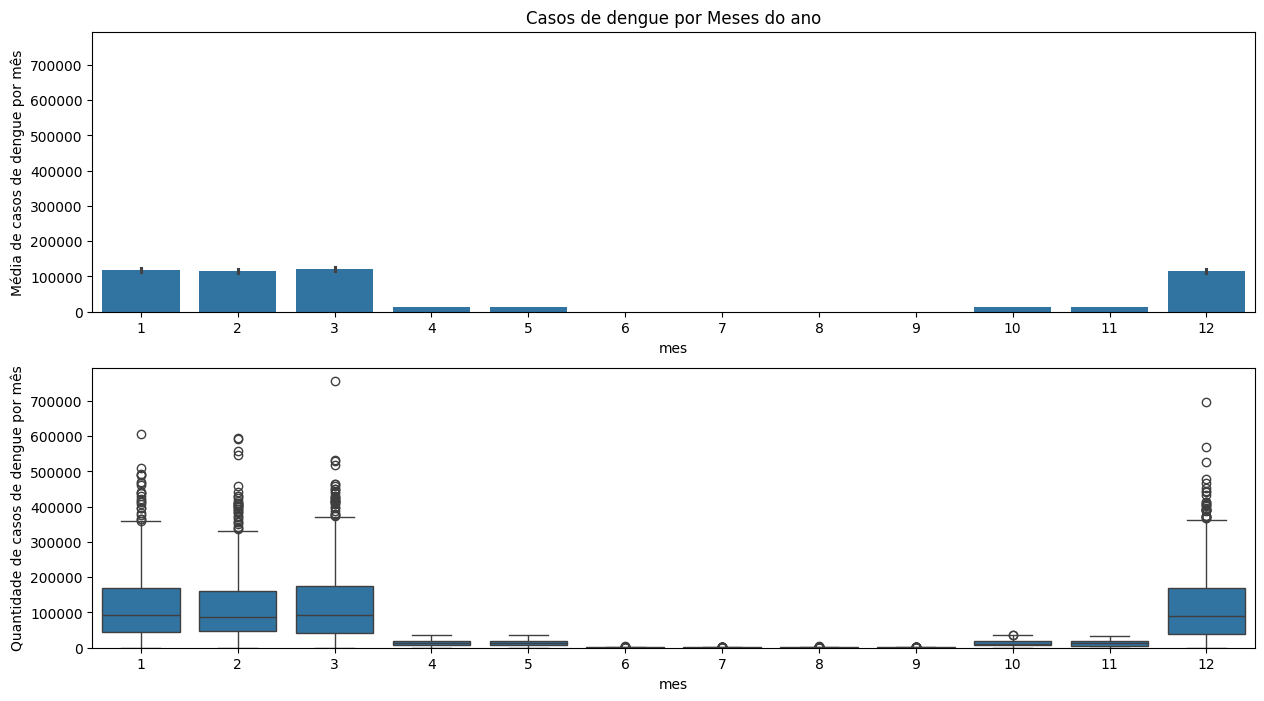

In [299]:
# Casos de dengue por mês é uma variável em que a média se distancia muito dos outliers e até do q3 
fig, ax = plt.subplots(2, 1, sharey=True, figsize=(15, 8))
sns.barplot(data=df, x='mes', y='casos_de_dengue', ax=ax[0])
ax[0].set_title('Casos de dengue por Meses do ano')
ax[0].set_ylabel('Média de casos de dengue por mês')
sns.boxplot(data=df, x='mes', y='casos_de_dengue', ax=ax[1])
ax[1].set_ylabel('Quantidade de casos de dengue por mês')
plt.show()

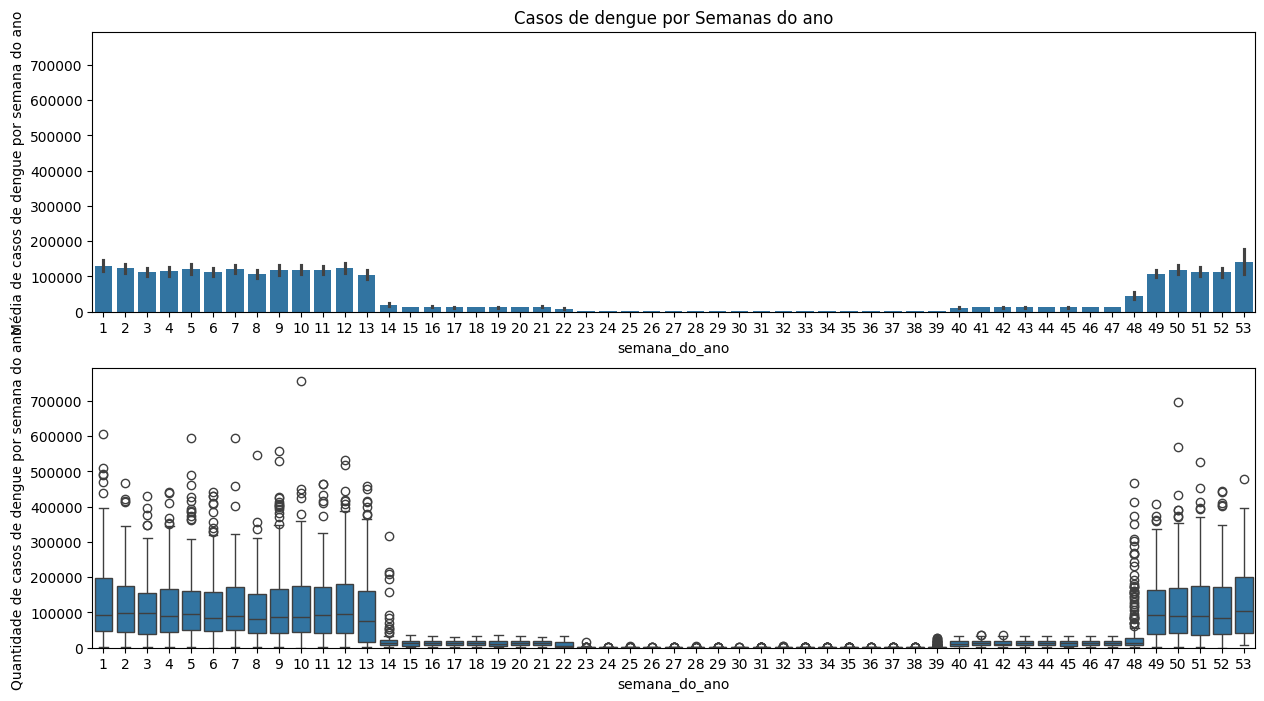

In [300]:
# Casos de dengue por semana_do_ano é uma variável em que a média se distancia muito dos outliers e até do q3 
fig, ax = plt.subplots(2, 1, sharey=True, figsize=(15, 8))
sns.barplot(data=df, x='semana_do_ano', y='casos_de_dengue', ax=ax[0])
ax[0].set_title('Casos de dengue por Semanas do ano')
ax[0].set_ylabel('Média de casos de dengue por semana do ano')
sns.boxplot(data=df, x='semana_do_ano', y='casos_de_dengue', ax=ax[1])
ax[1].set_ylabel('Quantidade de casos de dengue por semana do ano')
plt.show()

<Figure size 1600x1200 with 0 Axes>

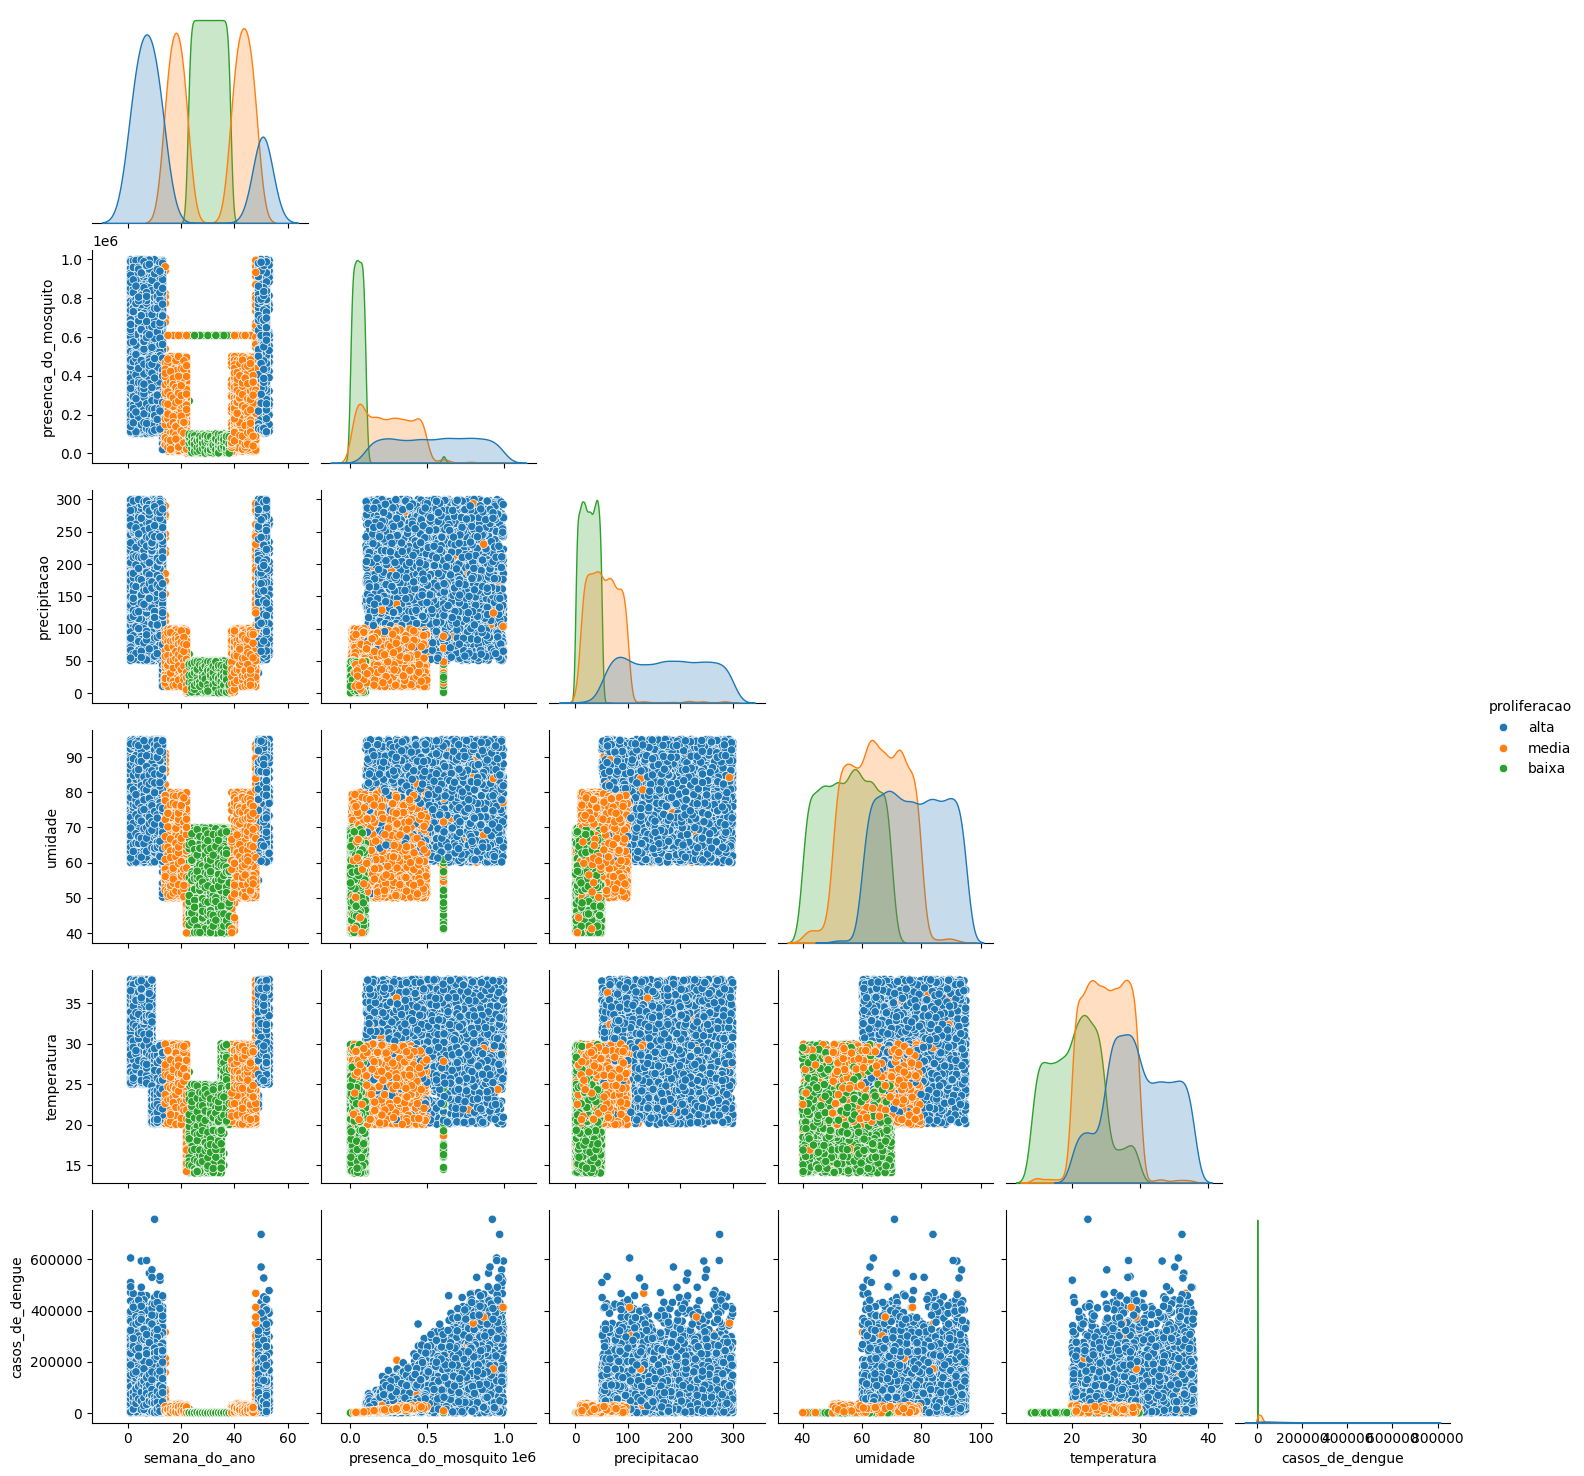

In [302]:
plt.figure(figsize=(16,12))
#sns.pairplot(df[['presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura', 'proliferacao', 'casos_de_dengue']], hue='proliferacao', corner=True)
#sns.pairplot(df_outliers[['presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura', 'outlier', 'semana_do_ano', 'casos_de_dengue']], hue='outlier', corner=True)
sns.pairplot(df_outliers[['semana_do_ano', 'presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura', 'proliferacao', 'casos_de_dengue']], hue='proliferacao', corner=True)
plt.show()

<Figure size 1600x1200 with 0 Axes>

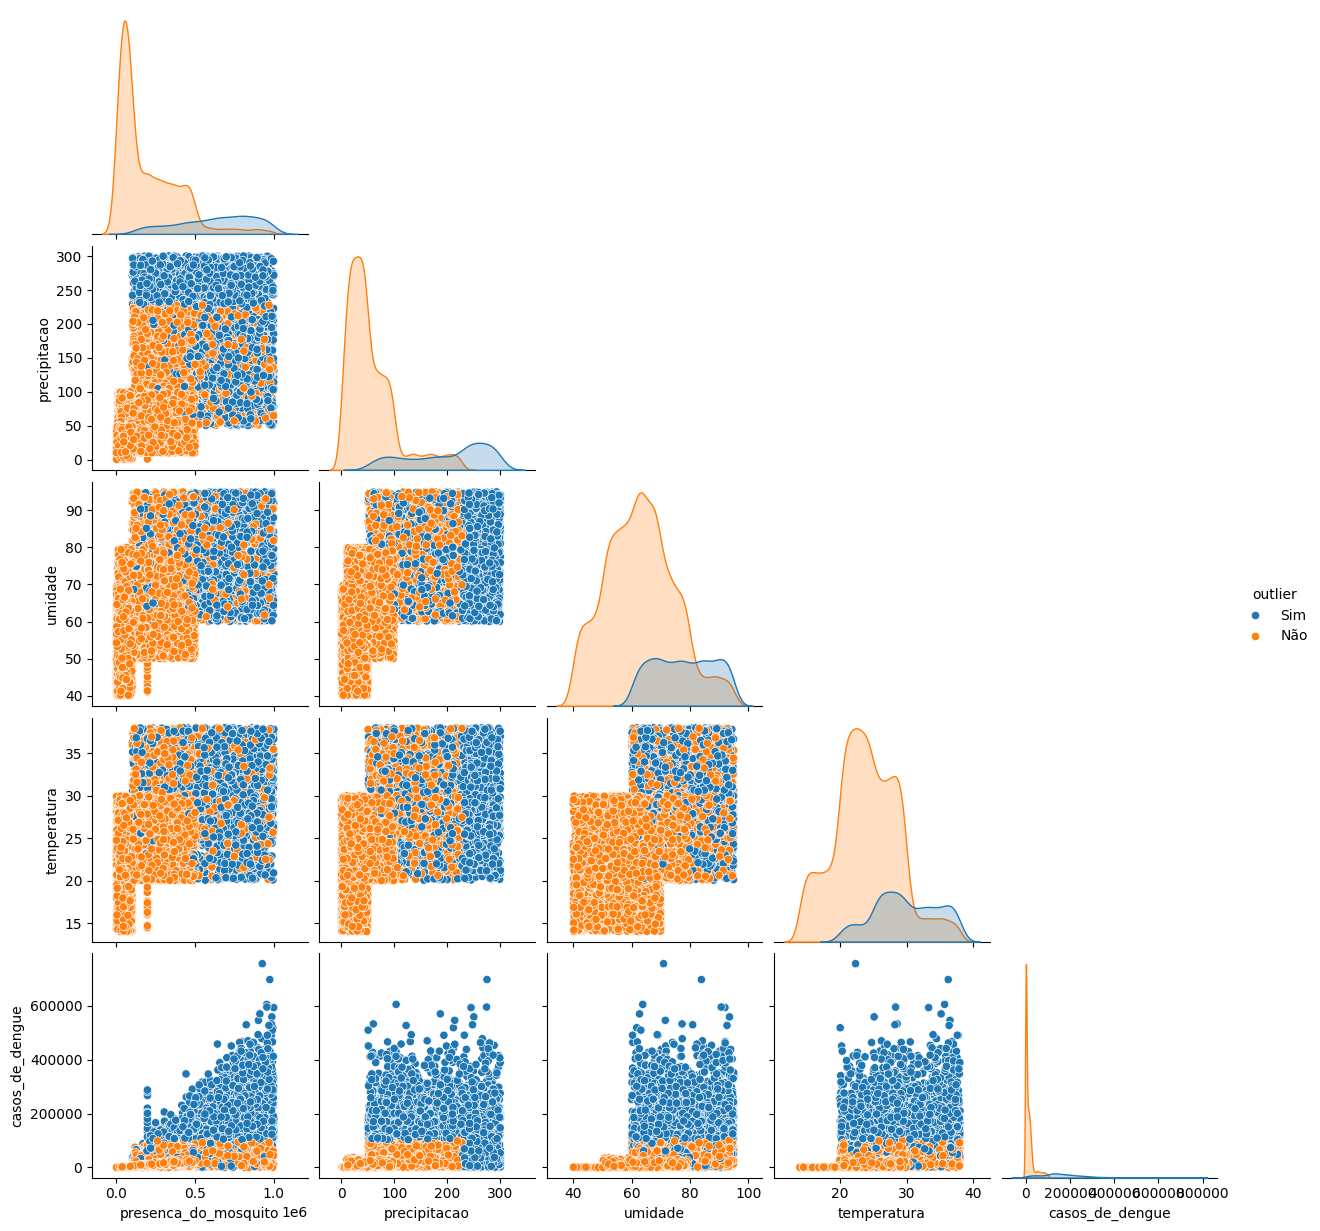

In [272]:
plt.figure(figsize=(16,12))
#sns.pairplot(df[['presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura', 'proliferacao', 'casos_de_dengue']], hue='proliferacao', corner=True)
sns.pairplot(df_outliers[['presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura', 'outlier', 'casos_de_dengue']], hue='outlier', corner=True)
plt.show()

### 4.2. Análise Bivariada

<Axes: xlabel='umidade', ylabel='casos_de_dengue'>

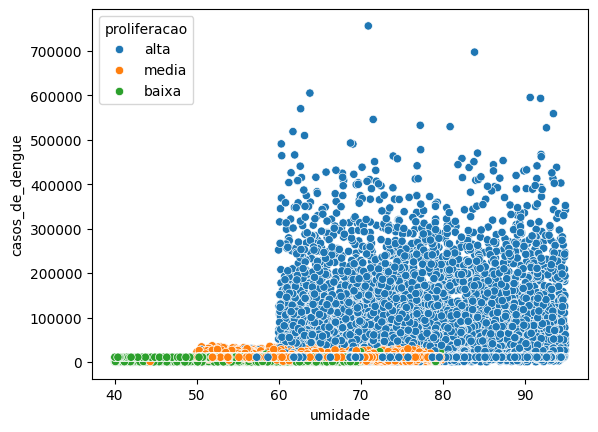

In [116]:
sns.scatterplot(x='umidade', y='casos_de_dengue', data=df, hue='proliferacao')

### 4.3. Análise Univariada

# III. Preparação dos dados

## 5. DATA PREPARATION

**Por que é importante?**

O aprendizado dos algoritmos de ML é facilitado com dados numéricos e na mesma escala.

**O que fazer?**
- Normalização: Diminuir o grau de importância das variáveis com maior range;
- Encoding: Transformar as variáveis categóricas em numéricas;
- Rescaling: Reescala para o intervalo entre 0 e 1;
- Transformation: [Transformação cíclica do time series](https://joaquinamatrodrigo.github.io/skforecast/0.8.1/faq/cyclical-features-time-series.html) (ex.: natureza cíclica dos meses, anos, semanas etc).

### 5.1. Separar arquivos de treino e validação

In [117]:
NUMERICAL_FEATURES = ['presenca_do_mosquito', 'precipitacao', 'umidade', 'temperatura']
CATEGORICAL_FEATURES = ['proliferacao']
CYCLICAL_FEATURES = ['mes', 'semana_do_ano']

FEATURES = NUMERICAL_FEATURES + CATEGORICAL_FEATURES + CYCLICAL_FEATURES
TARGET = 'casos_de_dengue'

SEED = 42

X = df[FEATURES]
y = df[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=SEED)

### 5.3. Normalização do fenômeno

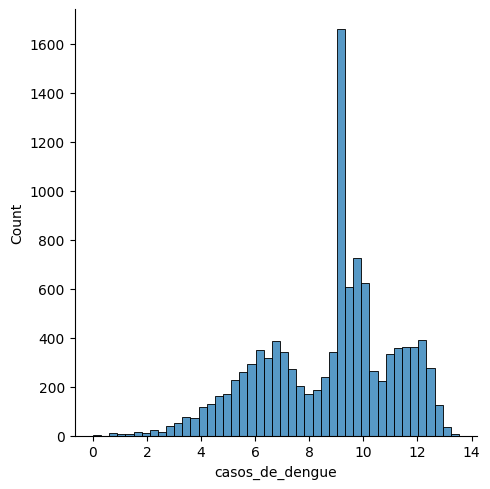

In [118]:
# Normalizar a variável dependente
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
sns.displot(y_train)

### 5.3. Demais transformações

In [119]:
# Rescalar variáveis Numéricas
numerical_transformer = MinMaxScaler()

# Encodar variáveis Categóricas
categorical_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)

# Transformar variáveis cíclicas
cyclical_transformer = ColumnTransformer(transformers=[
    ('sin1', sin_transformer(12), ['mes']),
    ('cos1', cos_transformer(12), ['mes']),
    ('sin2', sin_transformer(52), ['semana_do_ano']),
    ('cos2', cos_transformer(52), ['semana_do_ano'])
], remainder='drop')

# Pipeline
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, NUMERICAL_FEATURES),
    ('cat', categorical_transformer, CATEGORICAL_FEATURES),
    ('cyclical', cyclical_transformer, CYCLICAL_FEATURES)
])

df_encoded = preprocessor.fit_transform(X_train)
df_encoded.head()

,num__presenca_do_mosquito,num__precipitacao,num__umidade,num__temperatura,cat__proliferacao_alta,cat__proliferacao_baixa,cat__proliferacao_media,cyclical__sin1__mes,cyclical__cos1__mes,cyclical__sin2__semana_do_ano,cyclical__cos2__semana_do_ano
11947,0.039567,0.035827,0.034895,0.357766,0.0,1.0,0.0,-1.000000,-1.836970e-16,-0.992709,-0.120537
9964,0.413373,0.087901,0.578619,0.573973,0.0,0.0,1.0,0.866025,-5.000000e-01,0.970942,-0.239316
11752,0.193850,0.864883,0.438503,0.423156,1.0,0.0,0.0,1.000000,6.123234e-17,0.935016,0.354605
12239,0.021231,0.141308,0.235345,0.249931,0.0,1.0,0.0,-0.500000,-8.660254e-01,-0.120537,-0.992709
2754,0.042066,0.149318,0.446404,0.043762,0.0,1.0,0.0,-0.500000,-8.660254e-01,-0.239316,-0.970942


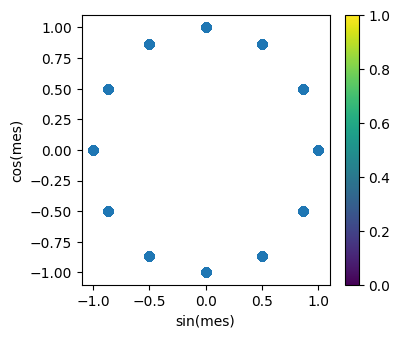

In [120]:
# Plot of the transformation
fig, ax = plt.subplots(figsize=(4., 3.5))
sp = ax.scatter(
        df_encoded["cyclical__sin1__mes"],
        df_encoded["cyclical__cos1__mes"]
#        c=df["mes"],
#        cmap='viridis'
     )
ax.set(
    xlabel="sin(mes)",
    ylabel="cos(mes)",
)
_ = fig.colorbar(sp)

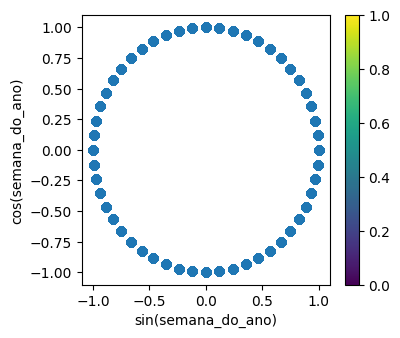

In [121]:
# Plot of the transformation
fig, ax = plt.subplots(figsize=(4., 3.5))
sp = ax.scatter(
        df_encoded["cyclical__sin2__semana_do_ano"],
        df_encoded["cyclical__cos2__semana_do_ano"],
#        c=df["mes"],
#        cmap='viridis'
     )
ax.set(
    xlabel="sin(semana_do_ano)",
    ylabel="cos(semana_do_ano)",
)
_ = fig.colorbar(sp)

# IV. Modelagem

Pipeline:
- Data cleaning
- Feature Engineering
- Transformations (Encoder dos categóricos, escala dos numéricos)

## 6. MACHINE LEARNING MODELING

In [122]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])

params = {
    'model': [
        DummyRegressor(),
        LinearRegression(),
        LassoCV(random_state=SEED),
        RidgeCV(),
        RandomForestRegressor(random_state=SEED),
        GradientBoostingRegressor(random_state=SEED),
        XGBRegressor(random_state=SEED)
    ]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', verbose=1)
grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [123]:
# Pegar o melhor modelo
grid_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['presenca_do_mosquito',
                                                   'precipitacao', 'umidade',
                                                   'temperatura']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['proliferacao']),
                                                 ('cyclical',
                                                  ColumnTransformer(transformers=[('sin1',
                                                                                   FunctionTransformer(func=<function sin_transfor...
                                                                                   FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x00000123838DFE20>),
                                                                                   ['mes']),
                                                                                  ('sin2',
                                                                                   FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x00000123838DF740>),
                                                                                   ['semana_do_ano']),
                                                                                  ('cos2',
                                                                                   FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x00000123838DFBA0>),
                                                                                   ['semana_do_ano'])]),
                                                  ['mes', 'semana_do_ano'])])),
                ('model', GradientBoostingRegressor(random_state=42))])

In [124]:
# Avaliar resultados
cv_results = pd.DataFrame(grid_model.cv_results_).set_index('param_model').sort_values('rank_test_score')
cv_results.loc[:,~cv_results.columns.str.contains('split|time')].T

param_model,GradientBoostingRegressor(random_state=42),RandomForestRegressor(random_state=42),"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=42, ...)",RidgeCV(),LinearRegression(),LassoCV(random_state=42),DummyRegressor()
params,{'model': GradientBoostingRegressor(random_sta...,{'model': RandomForestRegressor(random_state=42)},"{'model': XGBRegressor(base_score=None, booste...",{'model': RidgeCV()},{'model': LinearRegression()},{'model': LassoCV(random_state=42)},{'model': DummyRegressor()}
mean_test_score,0.780554,0.769884,0.748568,0.736835,0.736833,0.736664,-0.000925
std_test_score,0.004422,0.005126,0.007618,0.003977,0.003967,0.004023,0.001041
rank_test_score,1,2,3,4,5,6,7


# V. Validação

## 7. HYPERPARAMETER FINE TUNING

### 7.1. GridSearchCV

In [125]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=SEED))
])

params = {
    'model__learning_rate': [0.1, 0.01, 1],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [250, 400, 800],
    'model__subsample': [1., .8]
}

grid_model = GridSearchCV(model_pipeline, params, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['presenca_do_mosquito',
                                                                          'precipitacao',
                                                                          'umidade',
                                                                          'temperatura']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['proliferacao']),
                                                                        ('cyclical',
                                                                         ColumnTransformer(transformers=[('sin1',
                                                                                                          FunctionTransforme...
                                                                                                          FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x00000123838DFBA0>),
                                                                                                          ['semana_do_ano'])]),
                                                                         ['mes',
                                                                          'semana_do_ano'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.01, 1],
                         'model__max_depth': [3, 4, 5],
                         'model__n_estimators': [250, 400, 800],
                         'model__subsample': [1.0, 0.8]},
             scoring='r2', verbose=2)

### 7.2. Validação

In [128]:
# Avaliar resultados do melhor modelo
cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
cv_results.loc[:,~cv_results.columns.str.contains('split|time')].head(5)

,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,mean_test_score,std_test_score
rank_test_score,,,,,,,
1,0.01,5,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.783102,0.005272
2,0.01,5,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.782739,0.004972
3,0.01,4,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.782623,0.005387
4,0.01,4,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.782588,0.005281
5,0.01,5,800,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.781840,0.005163


In [129]:
# Pegar o melhor modelo com seus melhores parâmetros
model_pipeline = grid_model.best_estimator_
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['presenca_do_mosquito',
                                                   'precipitacao', 'umidade',
                                                   'temperatura']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['proliferacao']),
                                                 ('cyclical',
                                                  ColumnTransformer(transformers=[('sin1',
                                                                                   FunctionTransformer(func=<function sin_transfor...
                                                                                   FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x00000123838DF740>),
                                                                                   ['semana_do_ano']),
                                                                                  ('cos2',
                                                                                   FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x00000123838DFBA0>),
                                                                                   ['semana_do_ano'])]),
                                                  ['mes', 'semana_do_ano'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=5,
                                           n_estimators=400, random_state=42,
                                           subsample=0.8))])

In [130]:
# Validação dos erros
y_pred = model_pipeline.predict(X_val)
get_metrics(np.expm1(y_val), np.expm1(y_pred))

{'R2': 0.4156440637575026,
 'MAE': 23772.730039310525,
 'MAPE': 2458389438994652.5,
 'RMSE': 55589.64407583255}

In [40]:
# Validação dos erros
y_pred = model_pipeline.predict(X_val)
get_metrics(np.expm1(y_val), np.expm1(y_pred))

{'R2': 0.5472050668421298,
 'MAE': 21178.237033039582,
 'MAPE': 1.3626581309497101,
 'RMSE': 51456.48503311078}

<Axes: xlabel='casos_de_dengue'>

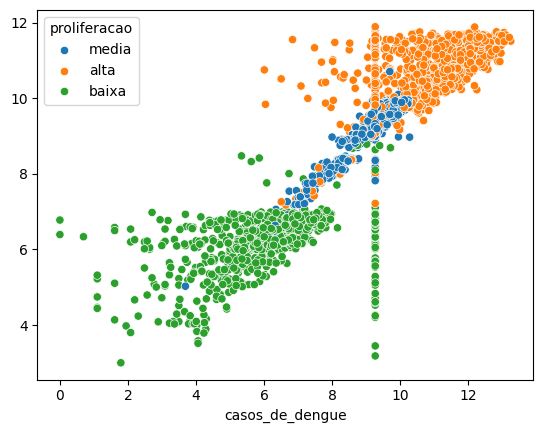

In [131]:
# Validação do gráfico
sns.scatterplot(x=y_val, y=y_pred, hue=X_val.proliferacao)

<Axes: xlabel='casos_de_dengue'>

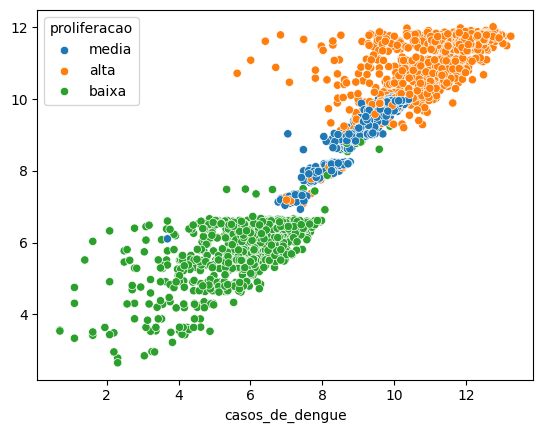

In [32]:
# Validação do gráfico
sns.scatterplot(x=y_val, y=y_pred, hue=X_val.proliferacao)

## 8. OPTIMIZATION

### 8.1. Feature Importance

- Data: Importância das features;
- Index: Nomes das features.

In [33]:
importances = pd.Series(
    data = model_pipeline.named_steps['model'].feature_importances_,
    index = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

importances.sort_values().plot.barh()

AttributeError: Transformer sin1 (type FunctionTransformer) does not provide get_feature_names_out.

### 8.2. Treino

### 8.3. Validação

## 9. ERROR TRANSLATION AND INTERPRETATION

### 9.1. Business Performance

### 9.2. Total Performance

# VI. Implantação

## 10. DEPLOY MODEL PRODUCTION

### 10.1. Salvar modelo

### 10.2. Salvar arquivo de submissão

In [ ]:
df_teste = teste.copy()
df_teste.shape

In [ ]:
# 2.2.3. Remover as linhas que não tem presença do mosquito
df_teste = df_teste.drop('casos_de_dengue', axis=1)

# 2.2.4. Converter variáveis
colunas_float = ['precipitacao',
                 'umidade',
                 'temperatura']

colunas_int = ['presenca_do_mosquito']

# Substituir ',' por '.'
for col in colunas_float:
    df_teste[col] = df_teste[col].apply(lambda x: x.replace(',', '.') if isinstance(x, str) else x)

# Converter colunas_float de object para float
for col in colunas_float:
    df_teste[col] = df_teste[col].astype(float)

# Converter date de object para datetime
df_teste['date'] = pd.to_datetime(df_teste['date'])

# 2.4.1. Separar data
# Criar colunas de dia, mes, ano e semana do ano
#df_teste['dia'] = df_teste['date'].dt.day
df_teste['mes'] = df_teste['date'].dt.month
#df_teste['ano'] = df_teste['date'].dt.year
df_teste['semana_do_ano'] = df_teste['date'].dt.weekofyear

# 'ano_semana': semana do ano, no formato string 'YYYY-WW'
#df_teste['ano_semana'] = df_teste['date'].dt.strftime( '%Y-%W' )

# 2.2.4. Preencher NA's
presenca_mediana = df_teste['presenca_do_mosquito'].median()
df_teste['presenca_do_mosquito'] = df_teste['presenca_do_mosquito'].fillna(presenca_mediana)

preencher_media_semana(df2, ['umidade', 'temperatura', 'precipitacao'])

# Converter colunas_int de object para float
for col in colunas_int:
    df_teste[col] = df_teste[col].astype(int)

# 2.2.5. Excluir os demais NA's
df_teste = df_teste.fillna(0)
#df_teste = df_teste.dropna().reset_index(drop=True)
df_teste['casos_de_dengue'] = np.nan

# 2.4. FEATURE ENGINEERING

# 2.4.2. Separar em 3 grupos
#df_teste['proliferacao'] = df_teste['semana_do_ano'].apply(lambda x: definir_proliferacao(x))

# 4.1. Normalização do fenômeno
df_teste['casos_de_dengue'] = np.log1p(df_teste['casos_de_dengue'])

# 4.2. Rescala de Variáveis Numéricas
mm = pp.MinMaxScaler()
ss = pp.StandardScaler()
rs = pp.RobustScaler()

df_teste['presenca_do_mosquito'] = mm.fit_transform(df_teste[['presenca_do_mosquito']])
df_teste['precipitacao']         = ss.fit_transform(df_teste[['precipitacao']])
df_teste['umidade']              = ss.fit_transform(df_teste[['umidade']])
df_teste['temperatura']          = ss.fit_transform(df_teste[['temperatura']])

# 4.3. Encodar variáveis categóricas
#df_teste = pd.get_dummies(df_teste, prefix=['status'], columns=['status'])
#df_teste = pd.get_dummies(df_teste, prefix=['proliferacao'], columns=['proliferacao'])

# 4.4. Transformação de natureza
# mes
df_teste['mes_sin'] = df_teste['mes'].apply( lambda x: np.sin( x * (2 * np.pi/12) ) )
df_teste['mes_cos'] = df_teste['mes'].apply( lambda x: np.cos( x * (2 * np.pi/12) ) )

# week_of_year
df_teste['semana_do_ano_sin'] = df_teste['semana_do_ano'].apply( lambda x: np.sin( x * (2 * np.pi/52) ) )
df_teste['semana_do_ano_cos'] = df_teste['semana_do_ano'].apply( lambda x: np.cos( x * (2 * np.pi/52) ) )

### Submission

In [ ]:
df_teste.columns

In [ ]:
aux_teste  = df_teste[cols_selected]
y_hat_test = model_xgb.predict(aux_teste)

In [ ]:
final_test = pd.concat([df_teste, pd.Series(np.expm1(y_hat_test), name='Casos de dengue')], axis=1)
final_test = final_test[['date', 'Casos de dengue']].sort_values('date')

In [ ]:
final_test.shape

In [ ]:
final_test = final_test.rename(columns={'date': 'Date', 'Casos de dengue': 'Casos de dengue'})
final_test

In [ ]:
# Exportar o arquivo
final_test.to_csv('datasets/submission_xgb_XX.csv', index=False)

### 10.3. Prever resultados do teste